# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [ ]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py


In [1]:
# Imports here
import torch
from torch import nn, optim, autograd
from torch import functional as F
import torchvision
from torchvision import transforms
import numpy as np
import flowers
from flowers import train, test, valid
import matplotlib 
import matplotlib.pyplot as plt
from collections import OrderedDict, deque
from helper import imshow
from torch.autograd import Variable

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(255) ,
                                                  torchvision.transforms.CenterCrop(224),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize([0.485, 0.456, 0.406], 
                                                                                    [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
image_datasets = torchvision.datasets.ImageFolder(data_dir, transform = data_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size = 64, shuffle=True)

In [4]:
#performing data transforms for each dataset, normalization, resize, centercrop and creating tensors for torch models
train_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(255),
                                                   torchvision.transforms.CenterCrop(224),
                                                   torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize([0.485, 0.456, 0.406], 
                                                                                    [0.229, 0.224, 0.225])])

test_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(255),
                                                  torchvision.transforms.CenterCrop(224),
                                                  torchvision.transforms.ToTensor()])

valid_transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(255),
                                                  torchvision.transforms.CenterCrop(224),
                                                  torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform = test_transforms)
valid_dataset = torchvision.datasets.ImageFolder(valid_dir, transform=valid_transforms)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size = 64, shuffle=True)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
#creating indexing for training dataset and unpacking images/labels from trainloader
images, labels = next(iter(trainloader))
print(train_dataset.class_to_idx)
[print(labels) for labels in next(iter(trainloader))]

{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99, '98': 100, '99'

[None, None]

In [7]:
#open image labels, creating dictionary from JSON format
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
labels = dict(cat_to_name)

In [8]:
print(labels)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [9]:
# TODO: Build and train your network
import torchvision.models as models

In [10]:
#selected vgg16 model
model = models.vgg16(pretrained=True)

In [11]:
model
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [12]:
for param in model.parameters():
    param.requires_grad = False
#create classifier and attach it to model, replacing the previous classifier w/output size
#to match our outputs and dropout layers, relu + logsoftmax output
classifier = nn.Sequential(nn.Linear(25088, 512),
                           nn.ReLU(inplace=True),               
                           nn.Dropout(p=0.2),
                           nn.Linear(512, 224),
                           nn.ReLU(inplace=True),               
                           nn.Dropout(p=0.2),
                           nn.Linear(224, 102),
                           nn.LogSoftmax(dim=1))

model.classifier = classifier
classifier.eval()

Sequential(
  (0): Linear(in_features=25088, out_features=512, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.2)
  (3): Linear(in_features=512, out_features=224, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.2)
  (6): Linear(in_features=224, out_features=102, bias=True)
  (7): LogSoftmax()
)

In [15]:
#define the training function for later use
def train(model, epochs, print_every):
    #choose number of epochs at function call
    epochs = epochs
    #print every x amount of images
    print_every = print_every
    #initiate total steps before starting loop
    steps = 0
    criterion = nn.NLLLoss()
    #create optimizer, set params to optimize with models classifier with lr
    optimizer = optim.Adam(model.classifier.parameters(), lr = 1e-4, weight_decay=1e-5)
    for epoch in range(epochs):
        #initiate running loss before starting loop
        running_loss = 0
        #iterate over training set and calculate loss
        #set model to train so layers are used appropriately
        model.train()
        for images, labels in trainloader:
            #collect each step as one full loop
            steps += 1
            #send images and labels to gpu if available
            images, labels = images.to(device), labels.to(device)
            #send model to gpu if available
            model.to(device)
            #initialize optimizer with zero gradients
            optimizer.zero_grad()
            #run model on images, collect output
            logps = model(images)
            #use loss function with input and target
            loss = criterion(logps, labels)
            #perform backpropogation
            loss.backward()
            #update models params with optimizer.step
            optimizer.step()
            
            #collect running loss and store with .item for later use 
            #(perhaps mean loss over dataset/epochs)
            running_loss += loss.item() 
        
            #if training set is done looping over images set the model to eval mode 
            if steps % print_every == 0:
    
                #turn off gradients because our model is not training and will
                with torch.no_grad():
                    #initialize losses
                    valid_losses = 0
                    #init accuracy
                    accuracy = 0
                    model.eval()
                    for images, labels in validloader:
                        classifier.to(device)
                        images, labels = images.to(device), labels.to(device)
                        #collect model output
                        logps = model(images)
                        #collect the loss input and target
                        valid_losses = criterion(logps, labels)
                        ps = torch.exp(logps)
                        #store in loss.item
                        valid_losses += valid_losses.item()
                        #unpack model output with topk probs, classes
                        top_p, top_class = ps.topk(1, dim=1)
                        #make sure labels and top class are in the same shape
                        equals = top_class == labels.view(*top_class.shape)
                        #use mean accuracy
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
                    #print test accuracy and loss
                    print(f"Validation Accuracy: {accuracy/len(validloader):.3f}.."
                          f"Validation Loss : {valid_losses/len(validloader):.3f}.."
                          f"Train Loss : {running_loss/len(trainloader):.3f}")
                    running_loss = 0
                    model.train()

In [16]:
#call to train model with the training function
train(model=model, epochs=10, print_every= 50)

Validation Accuracy: 0.492..Validation Loss : 0.424..Train Loss : 0.927
Validation Accuracy: 0.603..Validation Loss : 0.374..Train Loss : 0.683
Validation Accuracy: 0.605..Validation Loss : 0.335..Train Loss : 0.310
Validation Accuracy: 0.651..Validation Loss : 0.292..Train Loss : 0.279
Validation Accuracy: 0.664..Validation Loss : 0.244..Train Loss : 0.145
Validation Accuracy: 0.662..Validation Loss : 0.247..Train Loss : 0.149
Validation Accuracy: 0.685..Validation Loss : 0.223..Train Loss : 0.072
Validation Accuracy: 0.686..Validation Loss : 0.208..Train Loss : 0.083
Validation Accuracy: 0.674..Validation Loss : 0.241..Train Loss : 0.042
Validation Accuracy: 0.670..Validation Loss : 0.203..Train Loss : 0.050
Validation Accuracy: 0.665..Validation Loss : 0.237..Train Loss : 0.025
Validation Accuracy: 0.679..Validation Loss : 0.173..Train Loss : 0.034
Validation Accuracy: 0.676..Validation Loss : 0.215..Train Loss : 0.017
Validation Accuracy: 0.668..Validation Loss : 0.207..Train Loss 

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [17]:
# TODO: Do validation on the test set
#test on validation set
def test(data):
    epochs = 15
    #create loss function
    criterion = nn.NLLLoss()
    
    #turn off gradients because our model is not training and will
    #not need to update grads
    with torch.no_grad():
        for epochs in range(epochs):
            #init accuracy to zero
            accuracy = 0
            #initialize losses to 0
            test_losses = 0
            model.eval()
            for images, labels in data:
                #send images and labels to device
                images, labels = images.to(device), labels.to(device)
                #send model to cpu because we aren't training grads
                classifier.to(device)
                model.to(device)
                #collect model output
                logps = model(images)
                #exponentiate because model gives logarithmic output
                ps = torch.exp(logps)
                #collect the loss input and target
                test_losses = criterion(logps, labels)
                #store in loss.item
                test_losses += test_losses.item()
                #unpack model output with topk probs, classes
                top_p, top_class = ps.topk(1, dim=1)
                #make sure labels and top class are in the same shape
                equals = top_class == labels.view(*top_class.shape)
                #use mean accuracy
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
            #print validation accuracy and loss
            print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            print("Test Loss: {:.3f}".format(test_losses/len(testloader)))

In [18]:
#function call for validation loop
test(testloader)

Test Accuracy: 0.625
Test Loss: 0.252
Test Accuracy: 0.626
Test Loss: 0.169
Test Accuracy: 0.625
Test Loss: 0.250
Test Accuracy: 0.626
Test Loss: 0.185
Test Accuracy: 0.625
Test Loss: 0.228
Test Accuracy: 0.625
Test Loss: 0.224
Test Accuracy: 0.626
Test Loss: 0.220
Test Accuracy: 0.626
Test Loss: 0.193
Test Accuracy: 0.625
Test Loss: 0.235
Test Accuracy: 0.625
Test Loss: 0.204
Test Accuracy: 0.626
Test Loss: 0.210
Test Accuracy: 0.624
Test Loss: 0.266
Test Accuracy: 0.626
Test Loss: 0.215
Test Accuracy: 0.626
Test Loss: 0.217
Test Accuracy: 0.625
Test Loss: 0.265


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [19]:
# TODO: Save the checkpoint
#re-create optimizer/loss function and hyperparameters used to train the model
optimizer = optim.Adam(model.classifier.parameters(), lr = 1e-3, weight_decay= 1e-2)
criterion = nn.NLLLoss()
def save_checkpoint(model, path):
    epochs = 10
    
    #save the model with torch
    checkpoint= torch.save({
                'epochs': epochs,
                'arch': 'vgg16',
                'model': model.state_dict(),
                'classifier': classifier,
                'optimizer': optimizer.state_dict(),
                'criterion': criterion,
                'mapping': test_dataset.class_to_idx
                            }, path)
    return checkpoint

In [20]:
save_checkpoint(model=model, path='model.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [21]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(path):
    
    #load the path of the model along with all important features
    checkpoint = torch.load(path)
    model = models.__dict__[checkpoint['arch']](pretrained=True)
    model.classifier = checkpoint['classifier']      
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.load_state_dict(checkpoint['model'])
    class_to_idx = checkpoint['mapping']
    
    return model, checkpoint

In [22]:
load_checkpoint(path = 'model.pth')

(VGG(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace)
     (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU(inplace)
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): ReLU(inplace)
     (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): ReLU(inplace)
     (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace)
     (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace)
     (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (15): ReLU(inplace)
     (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [23]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
   #resize images to shortest side of 256 with aspect ratio
    from PIL import Image
    im = Image.open(image)
    
    #resize image to 256x256
    im = im.resize((256,256))
    
    #perform center cropping with images
    width, height = im.size          
    left = (width-224)/2
    top = (height-224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    
    im = im.crop((left, top, right, bottom))
    
    #create a numpy array with the image by dividing pixels and performing normalization
    np_image = np.asarray(im, dtype=np.float32)/255
    np_image -= np.array([0.485, 0.456, 0.406])
    np_image /= np.array([0.229, 0.224, 0.225])
    
    #transpose color channels because torch accepts different
    #color channel input
    np_image = np_image.transpose((2,0,1))
    
    
    return np_image

In [24]:
#make sure function call is working well with random image
image_path_ = 'flowers/test/100/image_07902.jpg'
test_image = process_image(image_path_)

In [25]:
test_image

array([[[-0.95342058, -0.98767012, -0.67942458, ..., -0.71367407,
         -0.71367407, -0.49105227],
        [-0.67942458, -0.37117901,  0.1425637 , ..., -0.67942458,
         -0.64517504, -0.3369295 ],
        [-0.54242653, -0.59380078, -0.43967801, ..., -0.66229981,
         -0.59380078, -0.19993149],
        ..., 
        [-1.00479484, -0.88492161, -0.91917109, ...,  1.06730032,
          0.87892807,  0.45080924],
        [-1.00479484, -0.98767012, -0.88492161, ...,  0.96455187,
          0.67343104,  0.41655976],
        [-1.02191961, -1.00479484, -0.7821731 , ...,  0.82755381,
          0.53643304,  0.29668647]],

       [[ 0.01260505,  0.01260505,  0.11764706, ..., -0.12745096,
         -0.03991595,  0.06512605],
        [ 0.2752102 ,  0.57282925,  1.04551828, ..., -0.09243696,
          0.03011206,  0.18767507],
        [ 0.34523821,  0.24019621,  0.59033626, ..., -0.07492996,
          0.08263306,  0.32773122],
        ..., 
        [-0.14495796, -0.10994396, -0.07492996, ...,

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [26]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.transpose((1,2,0))
    
    #undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    #clip image between 0-1 or else it displays with noise
    image = np.clip(image, 0,1)
    
    ax.imshow(image)
    if title: 
        ax.set_title(title)
    
    return ax

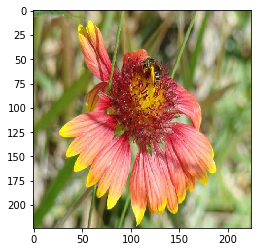

In [27]:
imshow(test_image)

In [28]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [29]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    for param in model.parameters():
        param.requires_grad = False
    #use cuda if cuda is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #set model to eval mode to prevent it from training
    model.eval()
    model.requires_grad = False
    #obtain model output, turn it into a torch tensor
    img = torch.from_numpy(process_image(image_path)).unsqueeze(0)
    model = model.to(device)
    img = img.to(device)
    #exponentiate model output and get topk classes results
    output = torch.exp(model(img)).data.cpu()
    #unpack output with probability and classes
    probs, classes = torch.topk(output, topk)
    probs = probs.data.numpy()[0]
    
    
    # Convert classes to indices
    idx_to_class = {v: k for k,v in test_dataset.class_to_idx.items()}
    top_classes = [idx_to_class[i] for i in classes.numpy()[0]]
    
    return probs, top_classes

In [30]:
predict(image_path_, model)

(array([ 0.56280828,  0.10044942,  0.08609592,  0.04384911,  0.03307858], dtype=float32),
 ['100', '50', '46', '90', '17'])

In [31]:
# TODO: Display an image along with the top 5 classes
def sanity_checking(probs, classes, image):
    #index the classes again 
    probs, classes = predict(image_path_, model)
    #match image labels with top classes
    class_name = [cat_to_name[i] for i in classes]
    y = np.arange(len(class_name))
    
    #plot image and provide the top 5 probabilities for classes which it could be
    image = imshow(process_image(image_path_), ax=None, title= 'sanity check')
    fig, ax = plt.subplots(figsize = [5,5])
    plt.barh(y, probs)
    ax.set_yticks(y)
    ax.set_yticklabels(class_name)
    plt.ylabel('Flower Class')
    plt.xlabel('Probability')
    
    plt.show()

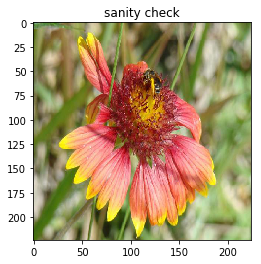

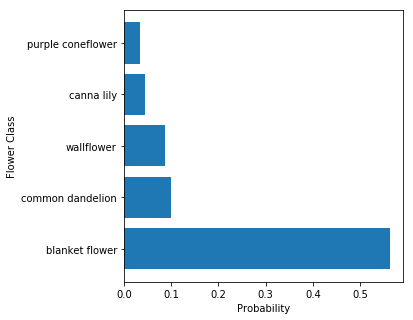

In [32]:
probs, classes = predict(image_path=image_path_, model=model)
sanity_checking(probs, classes, image=image_path_)